# Credit Card Fraud Detection

Note that this dataset has already been transformed using PCA to preserve confidentiality.

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv('./data/raw/creditcard.csv')

print(data.shape)
print(data.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


The data has already been transformed via PCA, so let's look at the remaining variables of interest.

# EDA

In [2]:
print(data[["Time","Amount","Class"]].info())
print()
print(data['Class'].value_counts())
print()
print(data[["Time","Amount","Class"]].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   Amount  284807 non-null  float64
 2   Class   284807 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 6.5 MB
None

Class
0    284315
1       492
Name: count, dtype: int64

                Time         Amount          Class
count  284807.000000  284807.000000  284807.000000
mean    94813.859575      88.349619       0.001727
std     47488.145955     250.120109       0.041527
min         0.000000       0.000000       0.000000
25%     54201.500000       5.600000       0.000000
50%     84692.000000      22.000000       0.000000
75%    139320.500000      77.165000       0.000000
max    172792.000000   25691.160000       1.000000


In [3]:
missing = data.isnull().sum().sum()
print(f"Total missing values: {missing}")

Total missing values: 0


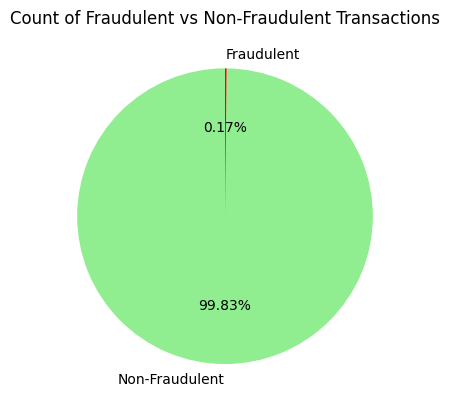

In [4]:
import matplotlib.pyplot as plt

fraud_ratio = data['Class'].value_counts(normalize=True)
fraud_ratio.plot(kind='pie', labels=['Non-Fraudulent', 'Fraudulent'], autopct='%1.2f%%', startangle=90, colors=['lightgreen', 'red'])
plt.title('Count of Fraudulent vs Non-Fraudulent Transactions')
plt.ylabel('')
plt.show()

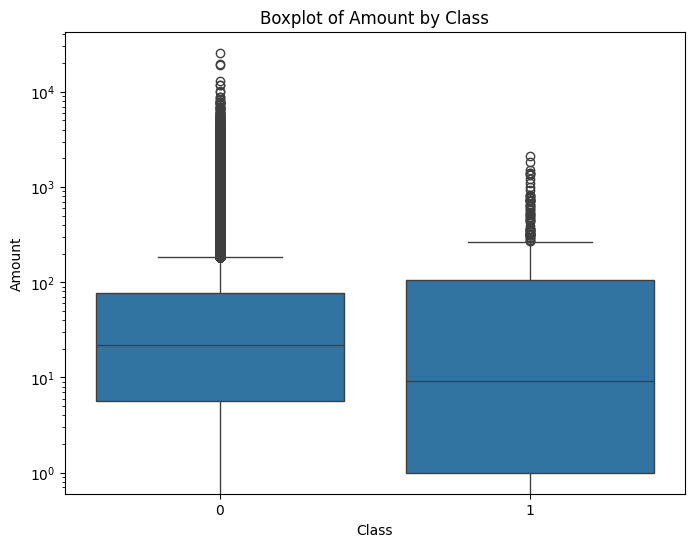

In [5]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=data)
plt.title('Boxplot of Amount by Class')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.yscale('log')
plt.show()

C:\Users\lukeh\AppData\Local\Temp\ipykernel_22812\1771472628.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudulent_data['Hour'] = (fraudulent_data['Time'] / 3600) % 24


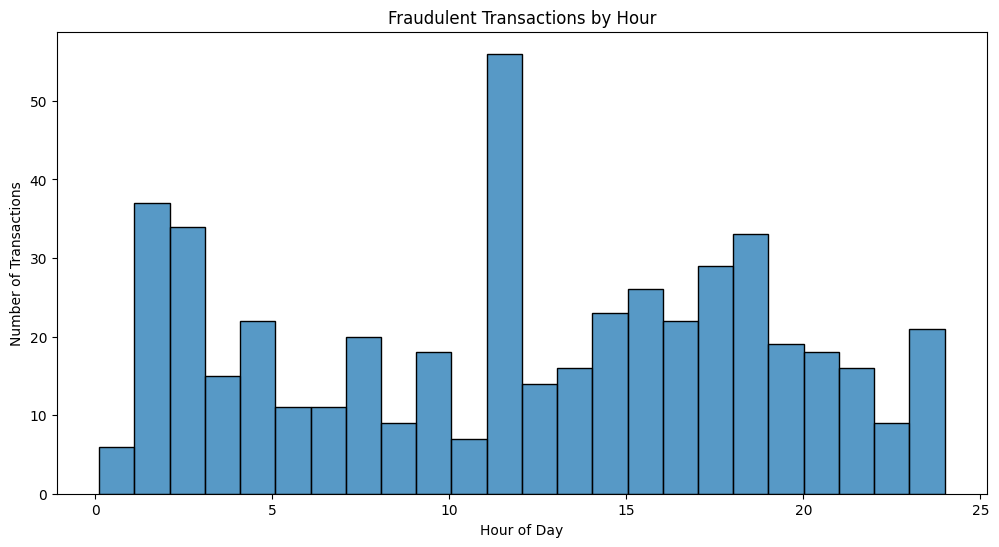

In [6]:
fraudulent_data = data[data["Class"] == 1]

# Assumes data starts at midnight
fraudulent_data['Hour'] = (fraudulent_data['Time'] / 3600) % 24

plt.figure(figsize=(12,6))
sns.histplot(data=fraudulent_data, x='Hour', bins=24)
plt.title('Fraudulent Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.show()

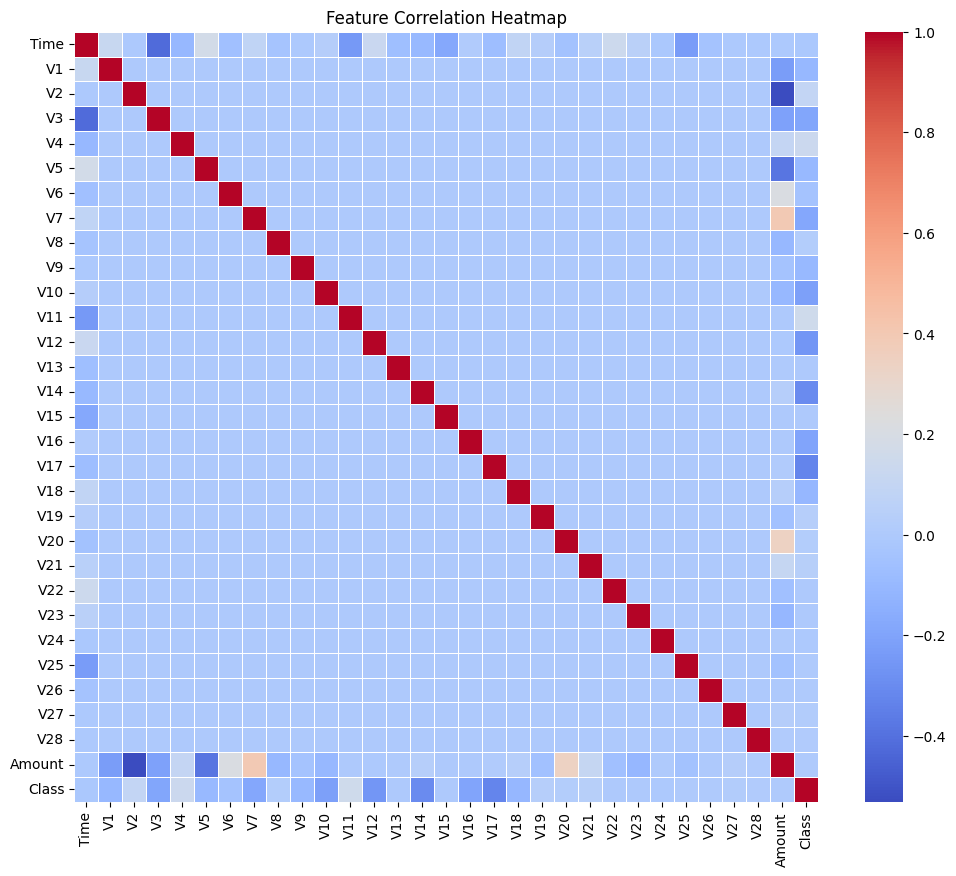

In [7]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

# Preprocessing

In [8]:
from sklearn.model_selection import train_test_split

X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train positive cases: {round(100*sum(y_train)/X_train.shape[0],3)}%")
print(f"Test positive cases: {round(100*sum(y_test)/X_test.shape[0],3)}%")

Train positive cases: 0.173%
Test positive cases: 0.172%


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# We want to scale Time and Amount, whilst leaving PCA columns untouched
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['Time', 'Amount'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 5: Fit model
pipeline.fit(X_train, y_train)


,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scale', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962



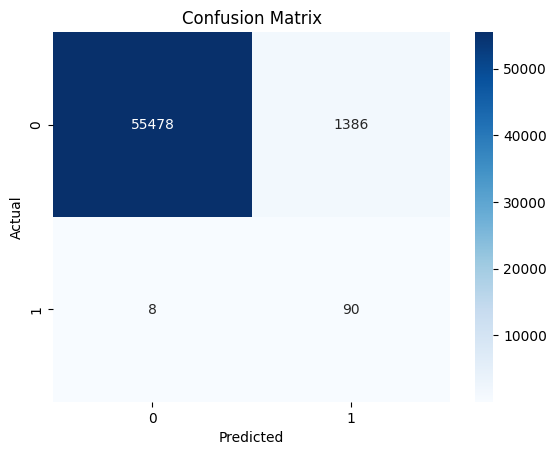

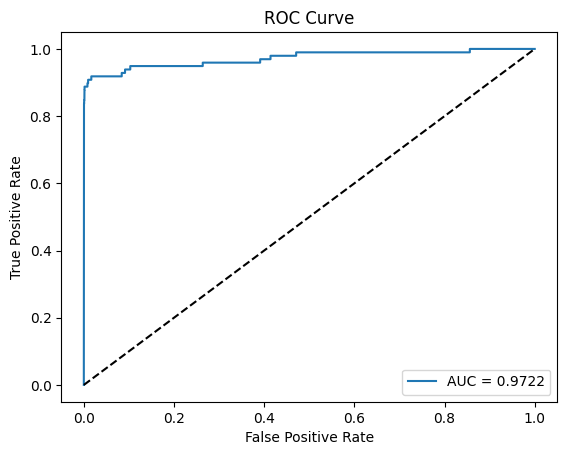

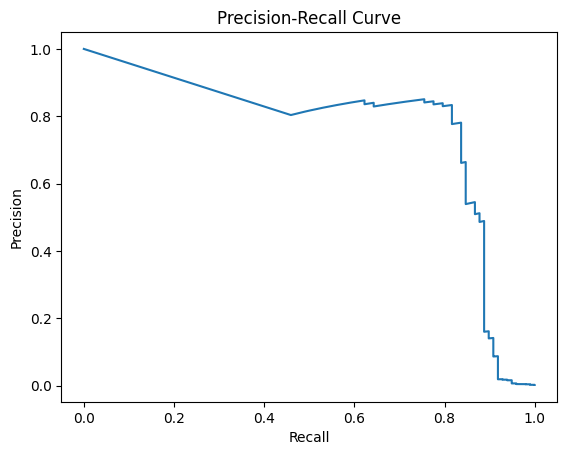

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Classification Report
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [14]:
# Did this with GPT 3.5 - switching to GPT 4o and Credit Risk Modelling first. Revisit and go over with GPT 4o.